# Spatial Interpolation of WQ data

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
arcpy.env.overwriteOutput = True

# 1. Load Discrete Data and Continuous Data

In [2]:
# path = "E:/Projects/SEACAR_WQ_Pilot/"
# gis_path = path+'GIS_data/'

path = "D:/Water_Quailty/"
gis_path = path+'Test02202/'

In [4]:
dfDis_orig = pd.read_csv(path + r"OEAT_Discrete-2023-Jan-23.csv")
dfCon1_orig = pd.read_csv(path + r"OEAT_Continuous_1-2023-Jan-23.csv")
dfCon2_orig = pd.read_csv(path + r"OEAT_Continuous_2-2023-Jan-23.csv")

C:\arcpyenv\arcpygeo\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2 Preprocess Data
Preset function parameters

In [96]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
dry_start,dry_end = '11/01/2016','04/30/2017'
wet_start,wet_end = '05/01/2017','10/31/2017'

Function to preprocess dataframes

In [6]:
def preprocessDis(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

def preprocessCon(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    # ------- Select data during daytime ------
    df["Hour"]     = df.apply(lambda x:x["timestamp"].strftime("%H"), axis=1)
    df["Hour"]     = df["Hour"].astype(int)
    df             = df[(df["Hour"]>=8) & (df["Hour"]<=18)]
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

Preprocess dataframes

In [7]:
dfCon1 = preprocessCon(dfCon1_orig, col_ls, para_ls)
dfCon2 = preprocessCon(dfCon2_orig, col_ls, para_ls)
dfDis  = preprocessDis(dfDis_orig, col_ls, para_ls)
dfCon  = pd.concat([dfCon1,dfCon2],ignore_index=True)

In [15]:
dfDis.to_csv(gis_path+"discrete_0214.csv")
dfCon.to_csv(gis_path+"continuous_0214.csv")

In [132]:
# In the future, we can open "discrete_0214.csv" and "continuous_0214.csv" to save time

In [3]:
dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

C:\arcpyenv\arcpygeo\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2. Combine Dis Data and Con Data

Combine dataframes

In [6]:
def combine_dis_con_dry(df_dis,df_con, year):
    
    year_start = str(int(year)-1)
    year_end   = str(year)
    dry_start,dry_end = ('11/01/'+year_start),('04/30/'+year_end)
    
    df_dis = df_dis[(df_dis['timestamp'] > dry_start)&(df_dis['timestamp'] < dry_end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    df_con = df_con[(df_con['timestamp'] > dry_start)&(df_con['timestamp'] < dry_end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

def combine_dis_con_wet(df_dis,df_con, year):
    
    year_start = str(int(year)-1)
    year_end   = str(year)
    wet_start,wet_end = ('05/01/'+year_end),('10/31/'+year_end)

    df_dis = df_dis[(df_dis['timestamp'] > wet_start)&(df_dis['timestamp'] < wet_end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    df_con = df_con[(df_con['timestamp'] > wet_start)&(df_con['timestamp'] < wet_end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

In [7]:
year = "2016"

dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Area = 'Estero Bay Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


## Read Managed Areas

In [8]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Estero Bay'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## Load Data

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

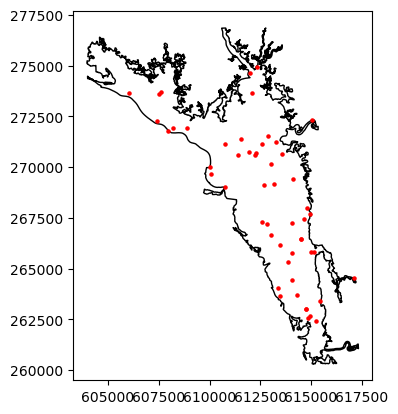

In [10]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

In [25]:
extent

'603939.79527388 260325.49855228 617308.05145584 276874.67363656'

In [54]:
def interpolation_method(year,method):
    select_method = str(method)
    if   select_method == "idw":
        print("This is Inverse Distance Weighting interpolation method")
        with arcpy.EnvManager(extent=extent, mask = gis_path+"ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
                 arcpy.ga.IDW(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path +Para_ab+ "dryIDW.lyrx",
                 out_raster   = gis_path +Para_ab+ "dryIDW.tif"
                )

        with arcpy.EnvManager(extent=extent, mask = gis_path+"ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
                 arcpy.ga.IDW(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path +Para_ab+ "wetIDW.lyrx",
                 out_raster   = gis_path +Para_ab+ "wetIDW.tif"
                )
                
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryIDW.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)

            gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
            extentShp.plot(ax = axes[1], color='none', edgecolor='black')
            cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetIDW.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)       
                
    elif select_method == "ok":
        print("This is Ordinary Kriging interpolation method")
#       Calculate dry season
        search_radius = 20000
        with arcpy.EnvManager( extent = extent,outputCoordinateSystem = arcpy.SpatialReference(3086),mask=gis_path+"ch.shp", cellSize = 30):
            out_surface_raster = arcpy.sa.Kriging(in_point_features = gis_path+"Dry"+year+Para_ab+'.shp',
                                          z_field = "ResultValu",
                                          kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))                           
#                                          "Spherical 0.000486 # # #",
#                                          0.000764192085967863,
#                                          "VARIABLE 12",
        out_surface_raster.save(gis_path+Para_ab+"dryKriging.tif")
#       Calculate wet season
        with arcpy.EnvManager(extent = extent, mask =gis_path+"ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
            out_surface_raster = arcpy.sa.Kriging(gis_path+"Wet"+year+Para_ab+'.shp',
                                          "ResultValu",
                                         kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
#                                           "Spherical 0.000486 # # #",
#                                           0.000764192085967863,
#                                          "VARIABLE 12",
                                          
        out_surface_raster.save(gis_path+Para_ab+"wetKriging.tif")
        
#       Draw the map
        fig, axes = plt.subplots(1,2, figsize=(18, 8))
        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)
        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryKriging.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)
        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetKriging.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)

    elif select_method == "ebk":
        print("This is Empirical Bayesian Kriging interpolation method")
        start_time = time.time()

        with arcpy.EnvManager(extent = extent, mask = gis_path+"ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                              cellSize = 30, parallelProcessingFactor = "80%"):
            arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                                      z_field = "ResultValu", 
                                    # This layer is not generated  
                                      out_ga_layer = gis_path+Para_ab+"EBK_Dry_Layer",
                                      out_raster   = gis_path+Para_ab+"dryEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
            arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                                      z_field = "ResultValu", 
                                     # This layer is not generated  
                                      out_ga_layer = gis_path+Para_ab+"EBK_Wet_Layer",
                                      out_raster = gis_path+Para_ab+"wetEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
        print("--- Time lapse: %s seconds ---" % (time.time() - start_time))
        
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryEBK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)


        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetEBK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
#       Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)

    elif select_method == "rk":
        print("This is Regression Kriging interpolation method")
        ma_table = pd.read_csv(gis_path + "MA_table.csv")
        ra_fname = 'basy_{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_AreaID'].iloc[0].astype(str))
        fig, ax = plt.subplots(1, figsize=(18, 8))

        fig.suptitle("{} (covariate: {}).".format(Area, 'basymetry'),fontsize=20)

        gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = ax, color='none', edgecolor='black')
        cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path + "covariates/basymetry/basy_14.tif", "r+") as covar:
            band = covar.read(1)
            #band = numpy.ma.masked_array(band, mask=(band < -1000))
            #band = numpy.ma.masked_array(band, mask=(band > 1000))
            band = np.ma.masked_where((band < -100) | (band > 100), band)
            retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
            ax.set_title('Basymetry')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=ax,shrink=0.8)
            
        start_time = time.time()

        with arcpy.EnvManager(extent = extent, mask = gis_path+"ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                              cellSize = 30, parallelProcessingFactor = "80%"):
            out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                                                                   dependent_field = "ResultValu", 
                                                                  out_ga_layer = gis_path +Para_ab+ "dryRK_GA",
                                                                    out_raster = gis_path +Para_ab+ "dryRK.tif",
                                                                  in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                                   transformation_type = 'EMPIRICAL',
                                                                  search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5)) 

            out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                                                                   dependent_field = "ResultValu",
                                                                  out_ga_layer = gis_path +Para_ab+ "wetRK_GA",
                                                                  out_raster = gis_path +Para_ab+ "wetRK.tif",
                                                                  in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                                   transformation_type = 'EMPIRICAL',
                                                                  search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))

        print("--- Time lapse: %s seconds ---" % (time.time() - start_time))
        
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryRK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)


        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetRK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)


# Ordinary Kriging

Run Oridinary Kriging for dry season data

This is Ordinary Kriging interpolation method


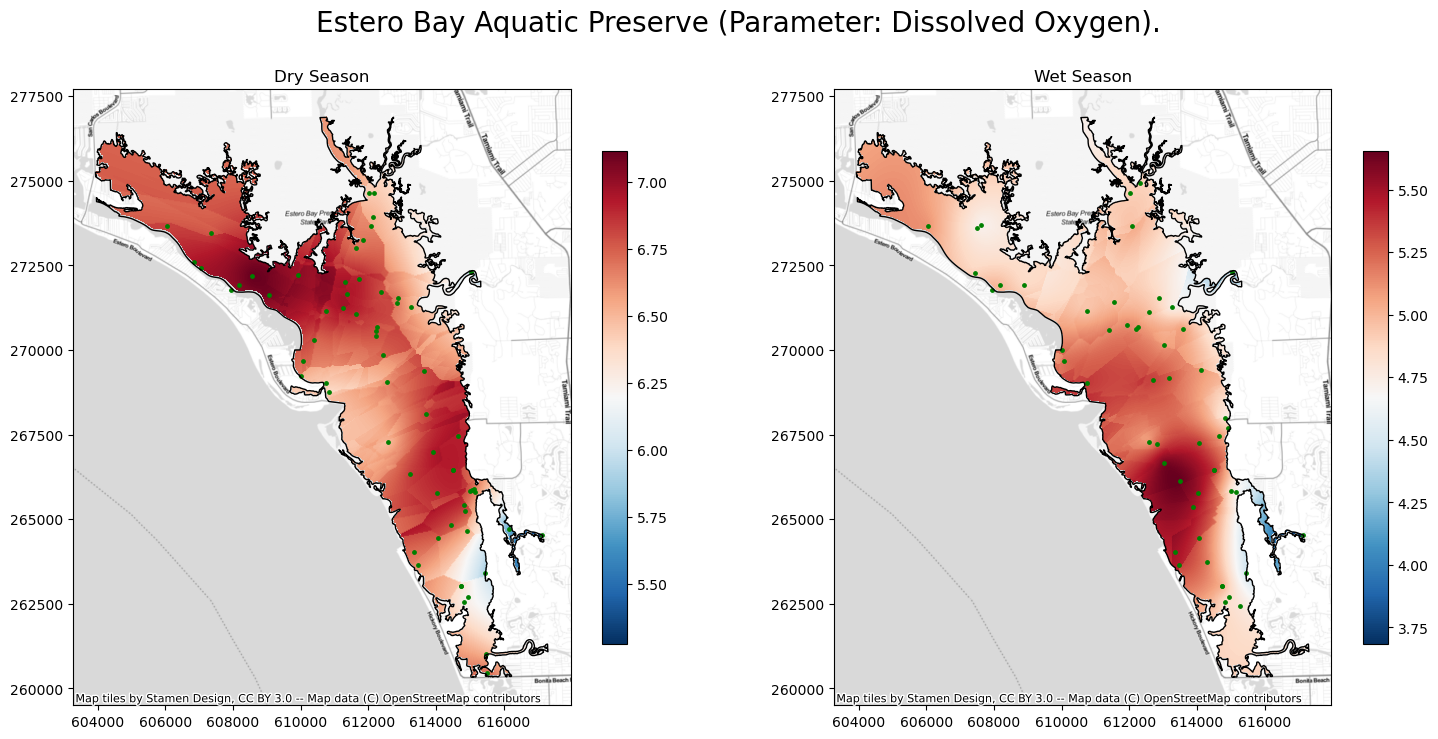

In [49]:
interpolation_method("2016","ok")

# Inverse Distance Weighting (IDW)

Run IDW for both wet and dry seasons

This is Inverse Distance Weighting interpolation method


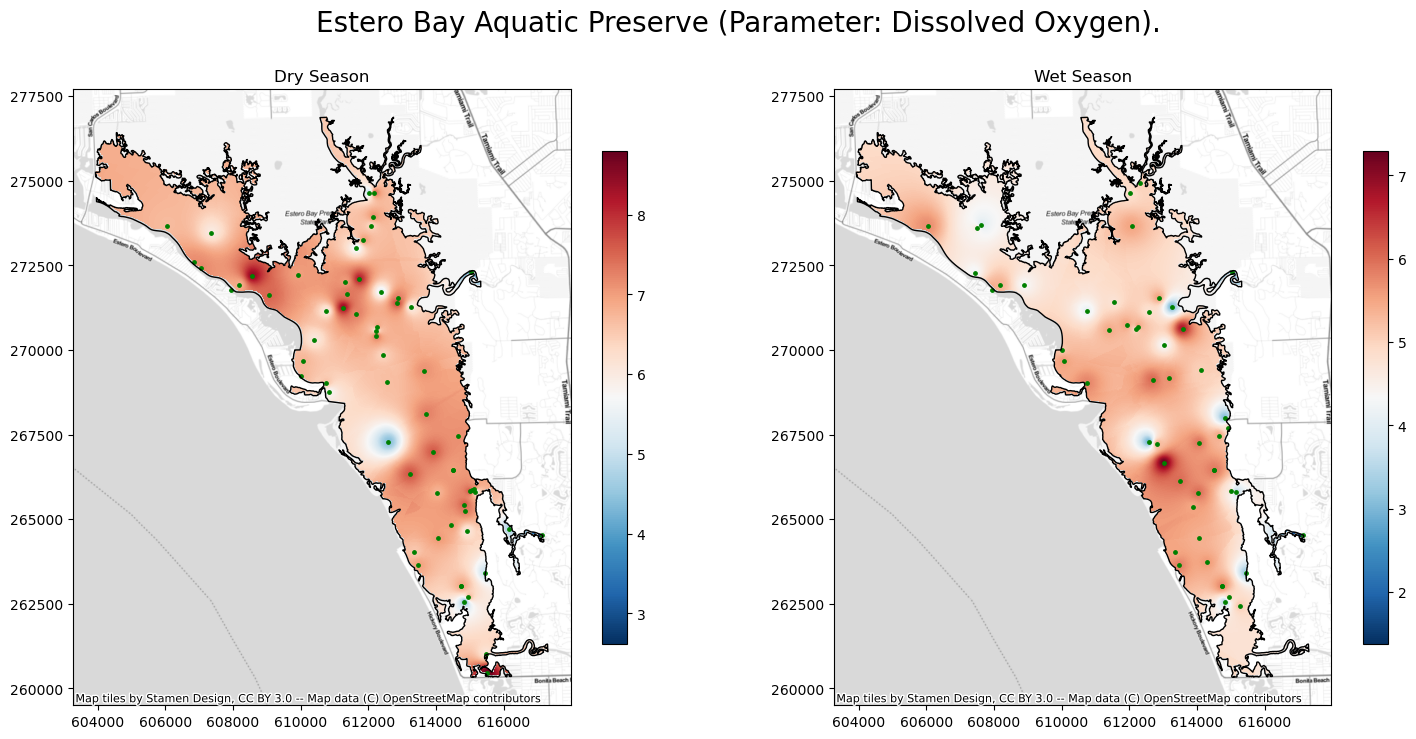

In [50]:
interpolation_method("2016","idw")

# Empirical Bayesian Kriging (EBK)

Run EBK for wet and dry seasons

This is Empirical Bayesian Kriging interpolation method
--- Time lapse: 69.55633926391602 seconds ---


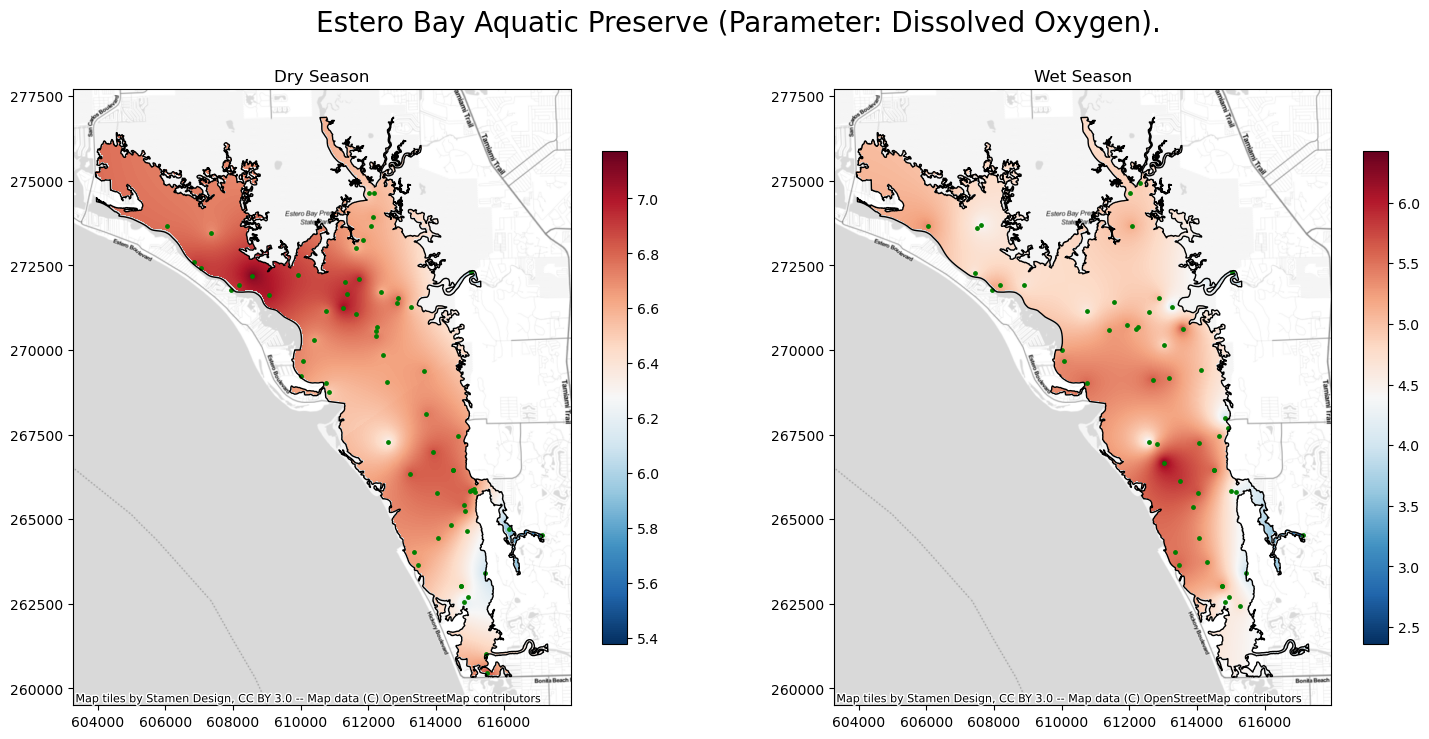

In [51]:
interpolation_method("2016","ebk")

# Regression Kriging (RK)

Run RK for wet and dry seasons

This is Regression Kriging interpolation method
--- Time lapse: 183.18676114082336 seconds ---


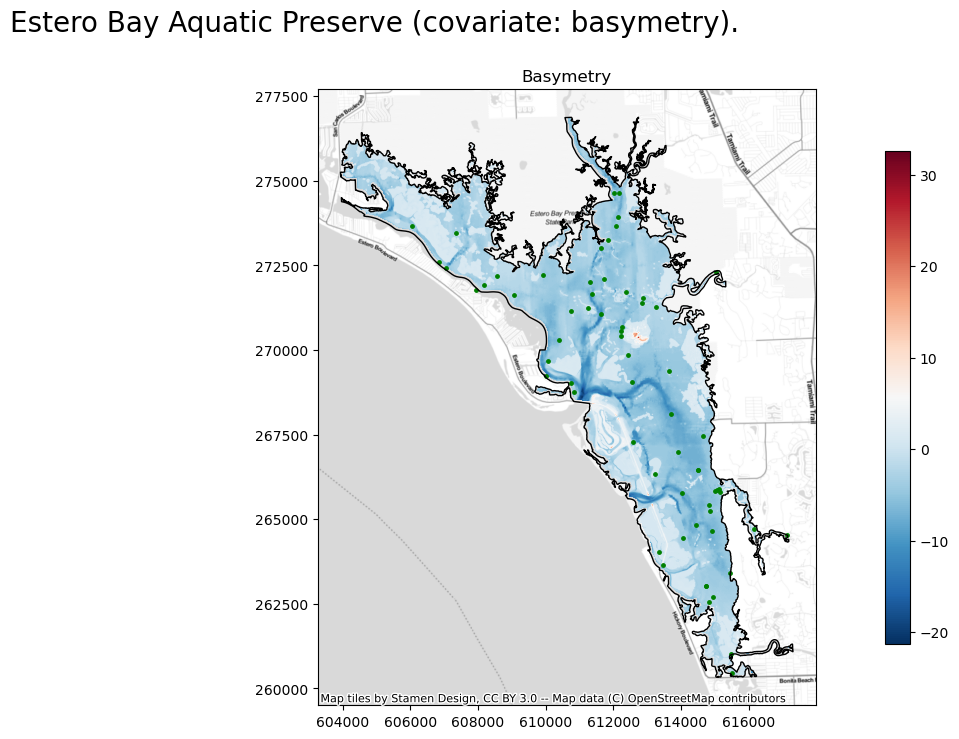

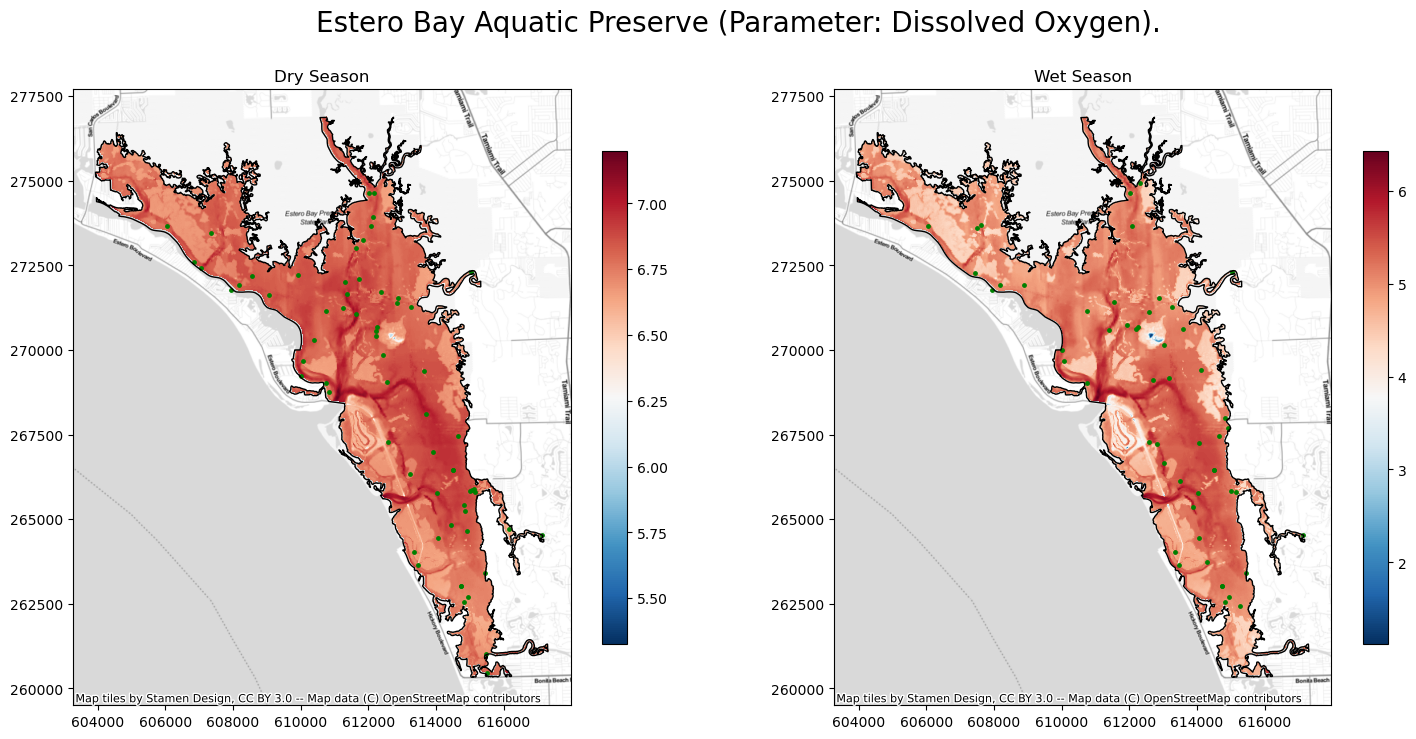

In [55]:
interpolation_method("2016","rk")

# Result Assessment

## Ordinary Kriging

In [58]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\DOwetok_GA.lyrx'>

In [59]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [60]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging    -0.0219                -0.0119               1.1988

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     0.0863                   0.04               1.0353

## Inverse Distance Weighting (IDW)

In [61]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\DOwetIDW_GA.lyrx'>

In [62]:
inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path+Para_ab + "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [63]:
cvResult.meanStandardized

'NaN'

In [64]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.1828                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               1.2322

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.0976                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               1.1434

## Empirical Bayesian Kriging

In [65]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\DOwetEBK_GA.lyrx'>

In [66]:
inLayer = gis_path+Para_ab + "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path+Para_ab + "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [67]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging     0.0169                 0.0073   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.1277

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging     0.0388                 0.0192   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.0655

## Regression Kriging

In [68]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\DOwetRK_GA.lyrx'>

In [69]:
inLayer = gis_path+Para_ab + "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path+Para_ab + "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [70]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0417                 -0.039               1.0938

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0448                 -0.041               1.0197

## Summary

In [71]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry = pd.concat([sumStat1,sumStat2])

In [72]:
print("Summary of interpolation assessment in dry season data")
sumStatDry

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging              -0.0219               -0.0119   
Inverse Distance Weighting     0.1828                   Nan   
Empirical Bayesian Kriging     0.0169                0.0073   
Regression Kriging            -0.0417                -0.039   

                            rootMeanSquareError  
Ordinary Kriging                         1.1988  
Inverse Distance Weighting               1.2322  
Empirical Bayesian Kriging               1.1277  
Regression Kriging                       1.0938

In [73]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet = pd.concat([sumStat3,sumStat4])

In [74]:
print("Summary of interpolation assessment in wet season data")
sumStatWet

Summary of interpolation assessment in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0863                  0.04   
Inverse Distance Weighting     0.0976                   Nan   
Empirical Bayesian Kriging     0.0388                0.0192   
Regression Kriging            -0.0448                -0.041   

                            rootMeanSquareError  
Ordinary Kriging                         1.0353  
Inverse Distance Weighting               1.1434  
Empirical Bayesian Kriging               1.0655  
Regression Kriging                       1.0197

# For Total Nitrogen and Salinity

In [76]:
year = "2016"

dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Area = 'Estero Bay Aquatic Preserve'
Para = 'Salinity'
Para_ab = "S"
SpatialRef = '3086'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


In [77]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Estero Bay'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [78]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

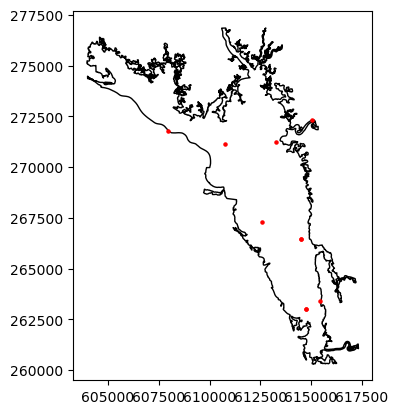

In [79]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [80]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

This is Ordinary Kriging interpolation method


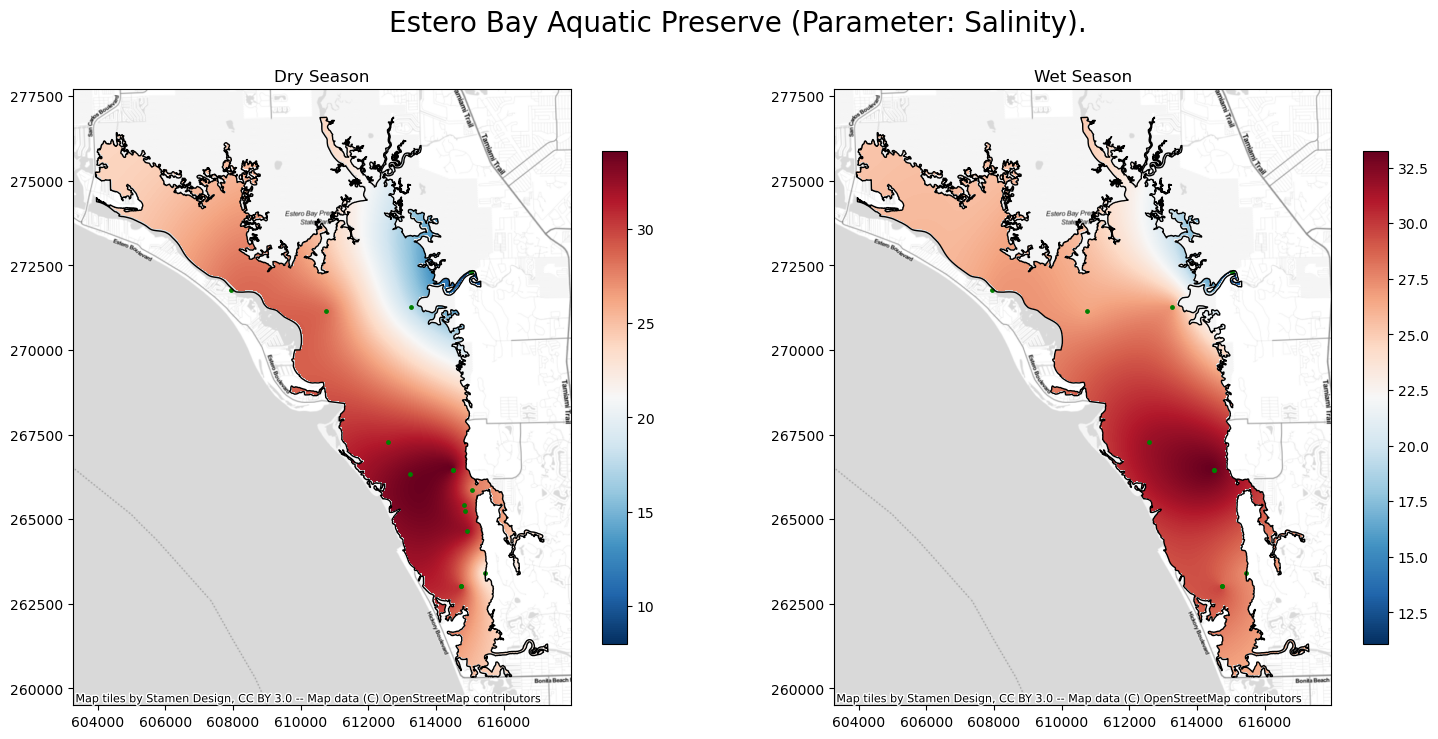

In [81]:
interpolation_method("2016","ok")

This is Inverse Distance Weighting interpolation method


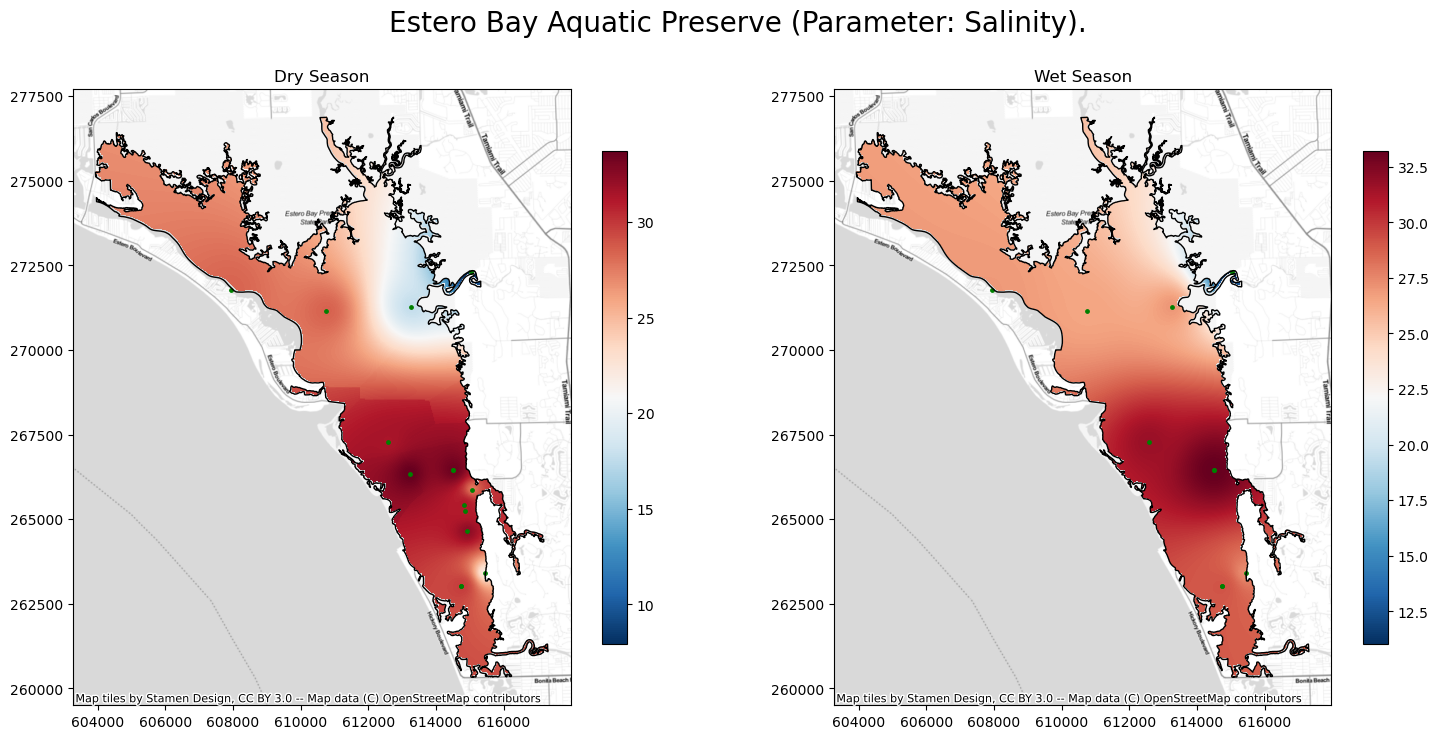

In [82]:
interpolation_method("2016","idw")

This is Empirical Bayesian Kriging interpolation method
--- Time lapse: 10.595112562179565 seconds ---


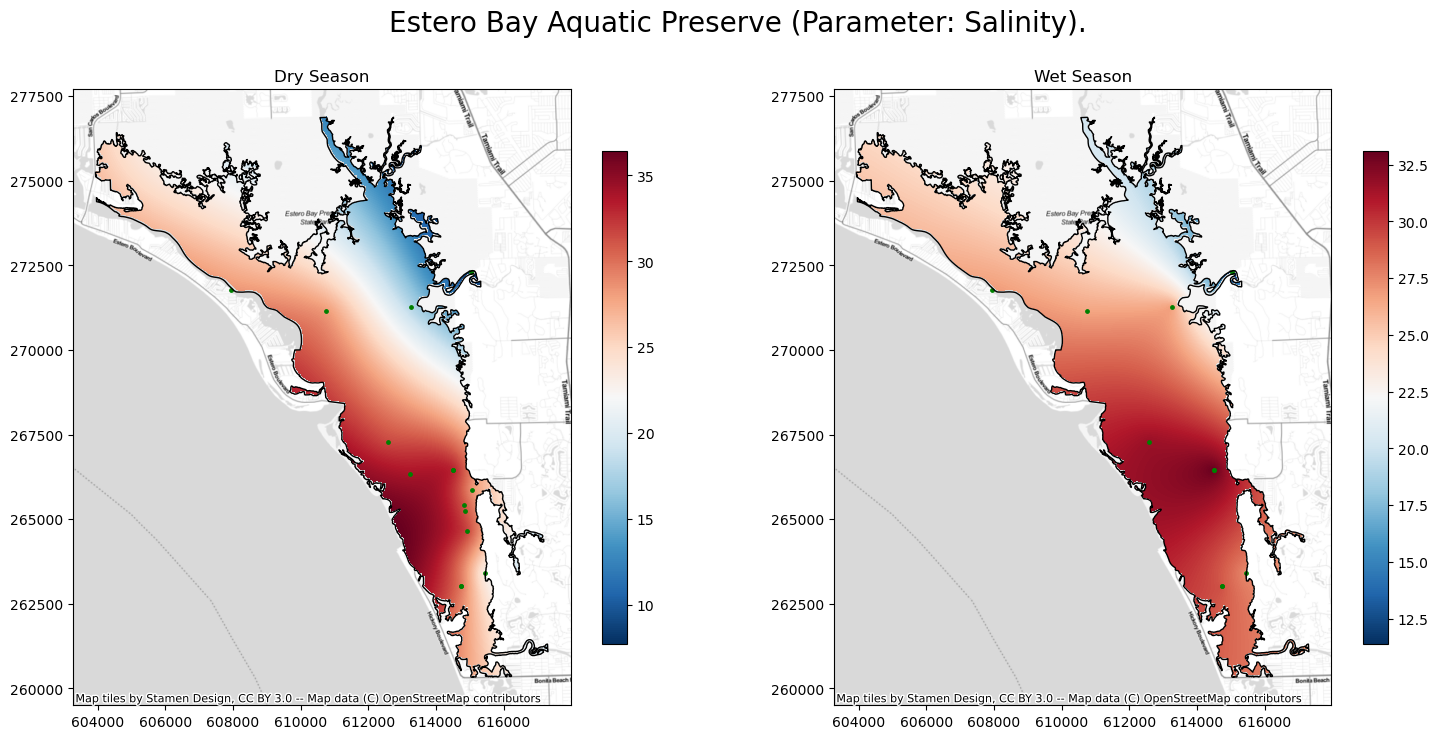

In [83]:
interpolation_method("2016","ebk")

This is Regression Kriging interpolation method
--- Time lapse: 96.36577224731445 seconds ---


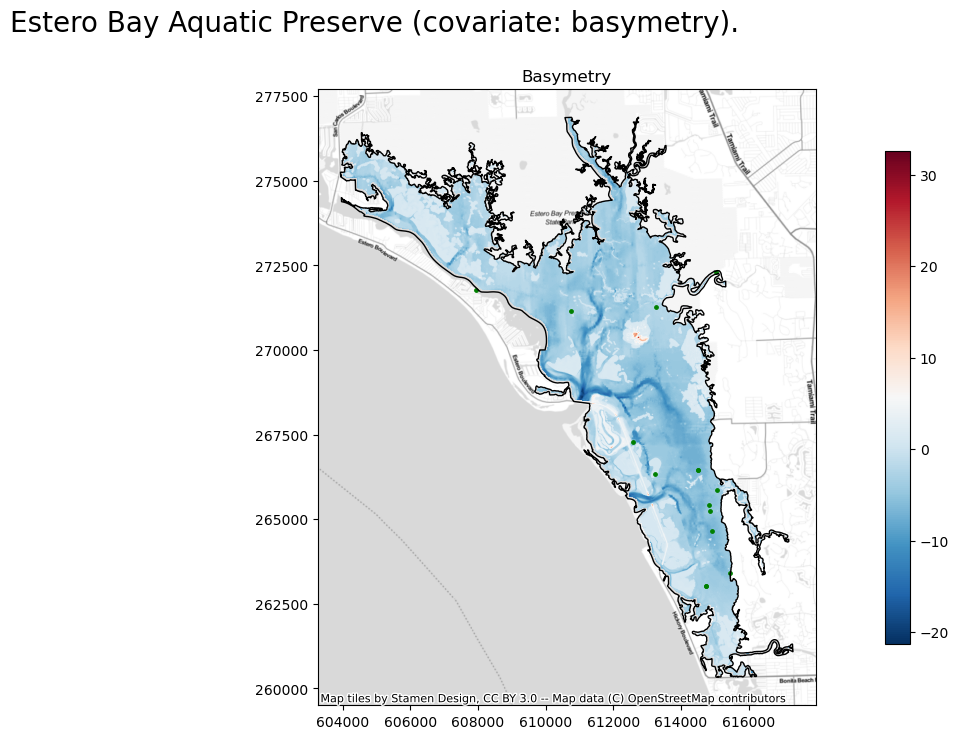

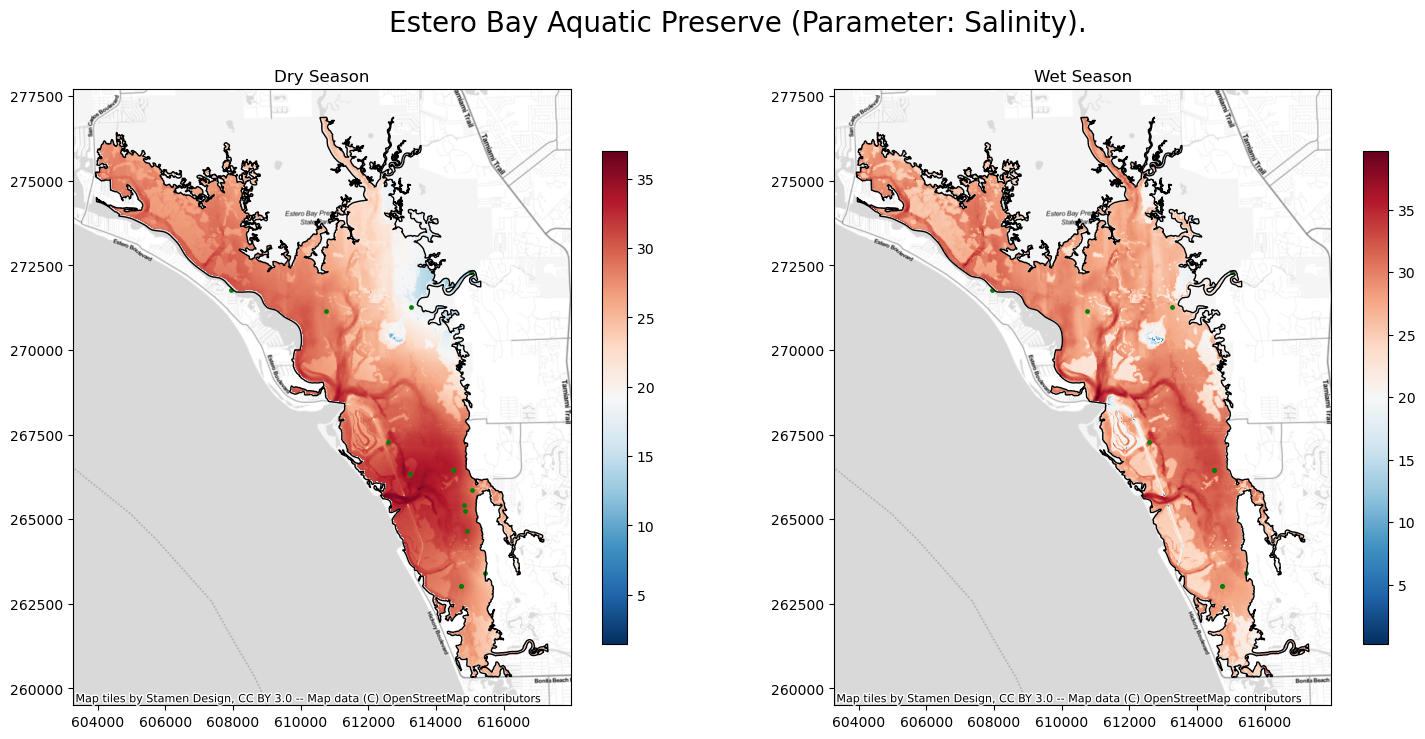

In [84]:
interpolation_method("2016","rk")

In [85]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\Swetok_GA.lyrx'>

In [86]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [87]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     1.1431                 0.4975               6.6931

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     1.3967                 0.6163               6.2481

In [88]:
arcpy.SaveToLayerFile_management(gis_path +Para_ab+ "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path +Para_ab+ "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\SwetIDW_GA.lyrx'>

In [89]:
inLayer = gis_path +Para_ab+ "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path +Para_ab+ "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [90]:
cvResult.meanStandardized

'NaN'

In [91]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     1.6566                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               5.3286

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     1.2946                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               5.7211

In [92]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\SwetEBK_GA.lyrx'>

In [93]:
inLayer = gis_path +Para_ab+ "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path +Para_ab+ "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [94]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging     0.8991                 0.1159   

                            rootMeanSquareError  
Empirical Bayesian Kriging                3.255

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging     1.0383                 0.1194   

                            rootMeanSquareError  
Empirical Bayesian Kriging               5.7064

In [95]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\SwetRK_GA.lyrx'>

In [96]:
inLayer = gis_path +Para_ab+ "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path +Para_ab+ "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [97]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging      0.619                 0.0755                4.041

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0646                 0.0425               4.4247

In [98]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry2 = pd.concat([sumStat1,sumStat2])

In [99]:
print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging               1.1431                0.4975   
Inverse Distance Weighting     1.6566                   Nan   
Empirical Bayesian Kriging     0.8991                0.1159   
Regression Kriging             0.6190                0.0755   

                            rootMeanSquareError  
Ordinary Kriging                         6.6931  
Inverse Distance Weighting               5.3286  
Empirical Bayesian Kriging               3.2550  
Regression Kriging                       4.0410

In [100]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet2 = pd.concat([sumStat3,sumStat4])

In [101]:
print("Summary of interpolation assessment in wet season data")
sumStatWet2

Summary of interpolation assessment in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               1.3967                0.6163   
Inverse Distance Weighting     1.2946                   Nan   
Empirical Bayesian Kriging     1.0383                0.1194   
Regression Kriging            -0.0646                0.0425   

                            rootMeanSquareError  
Ordinary Kriging                         6.2481  
Inverse Distance Weighting               5.7211  
Empirical Bayesian Kriging               5.7064  
Regression Kriging                       4.4247

# For Total Nitrogen

In [102]:
year = "2016"

dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Area = 'Estero Bay Aquatic Preserve'
Para = 'Total Nitrogen'
Para_ab = "TN"
SpatialRef = '3086'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


In [103]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Estero Bay'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [104]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

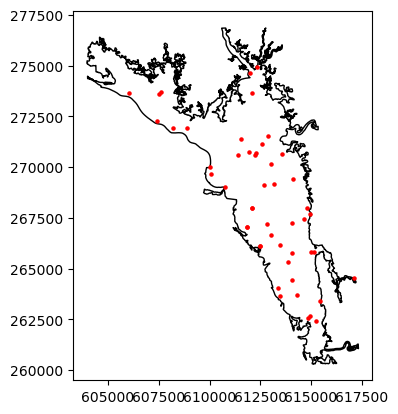

In [105]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [106]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

This is Ordinary Kriging interpolation method


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


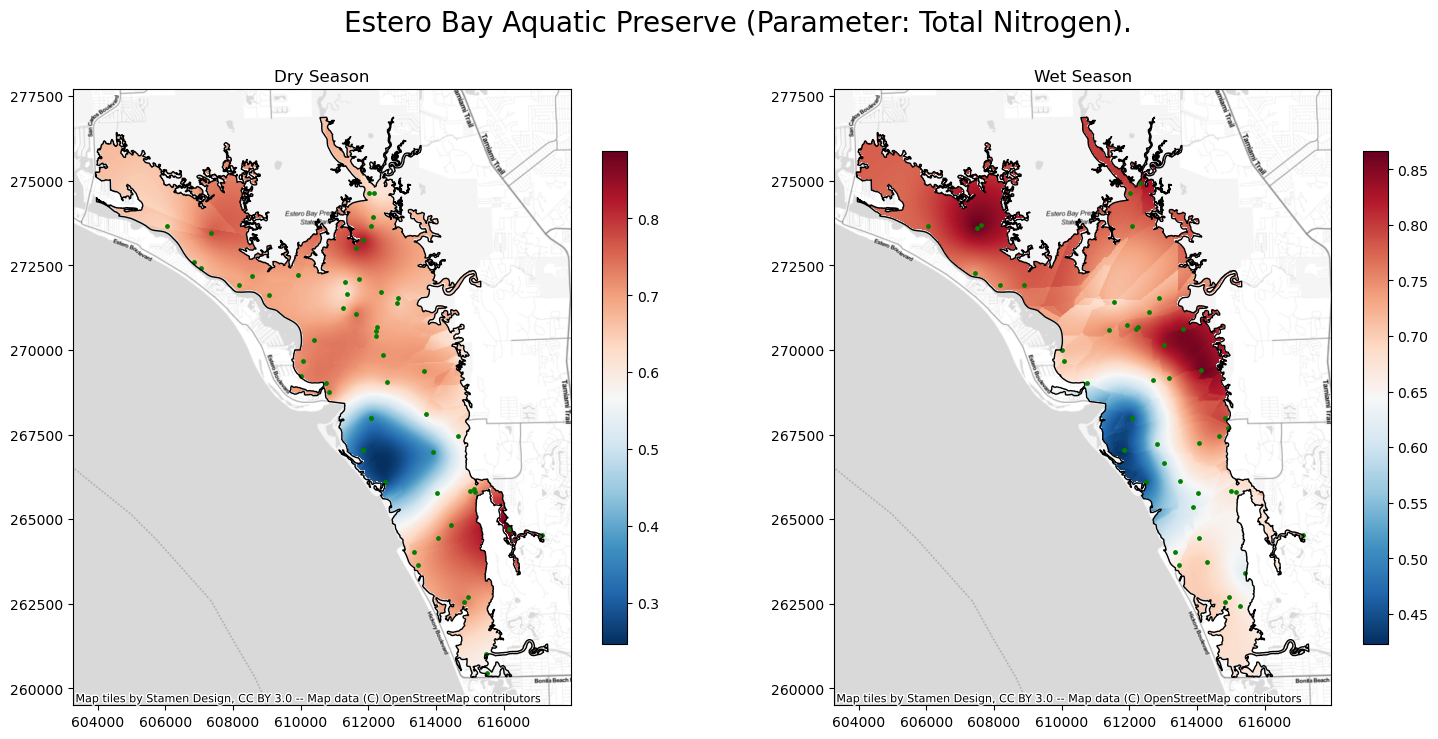

In [108]:
interpolation_method("2016","ok")

This is Inverse Distance Weighting interpolation method


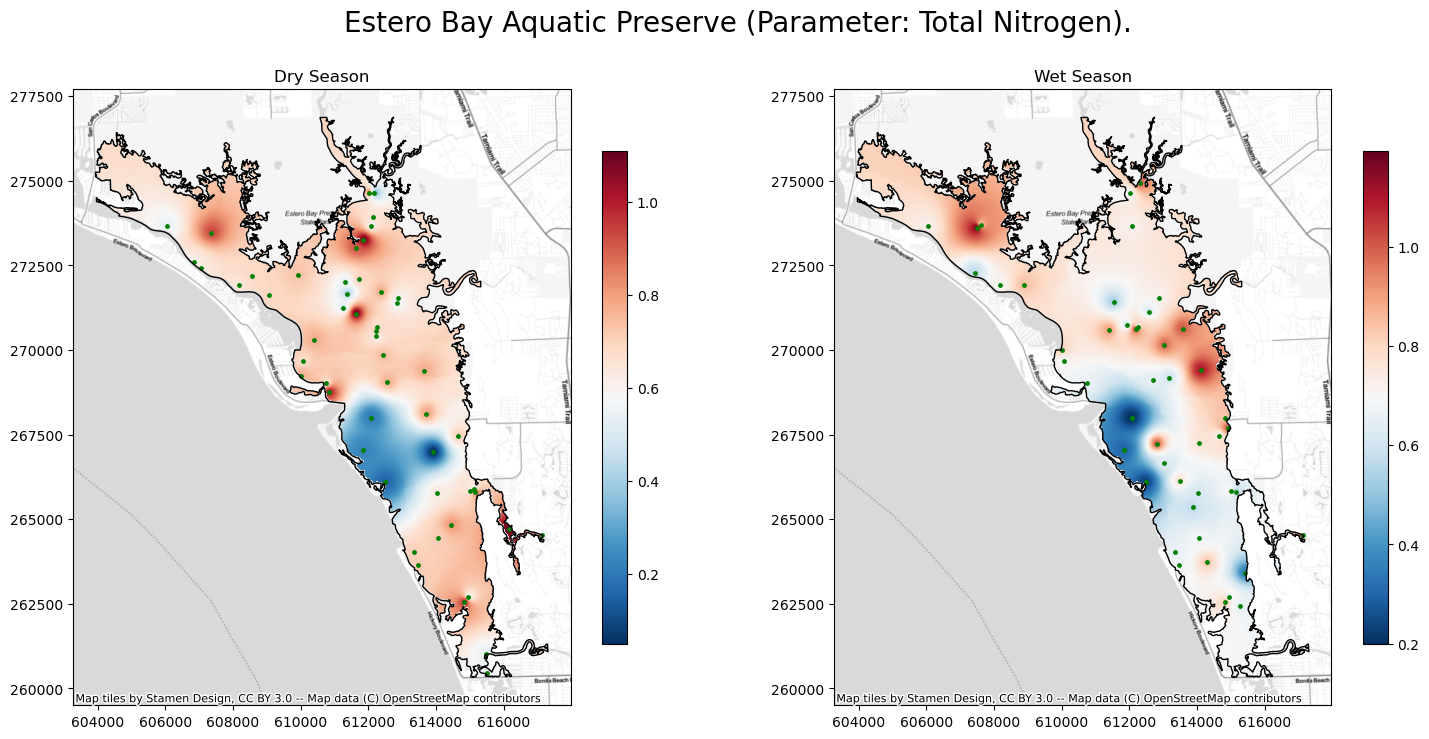

In [109]:
interpolation_method("2016","idw")

This is Empirical Bayesian Kriging interpolation method
--- Time lapse: 61.10557174682617 seconds ---


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


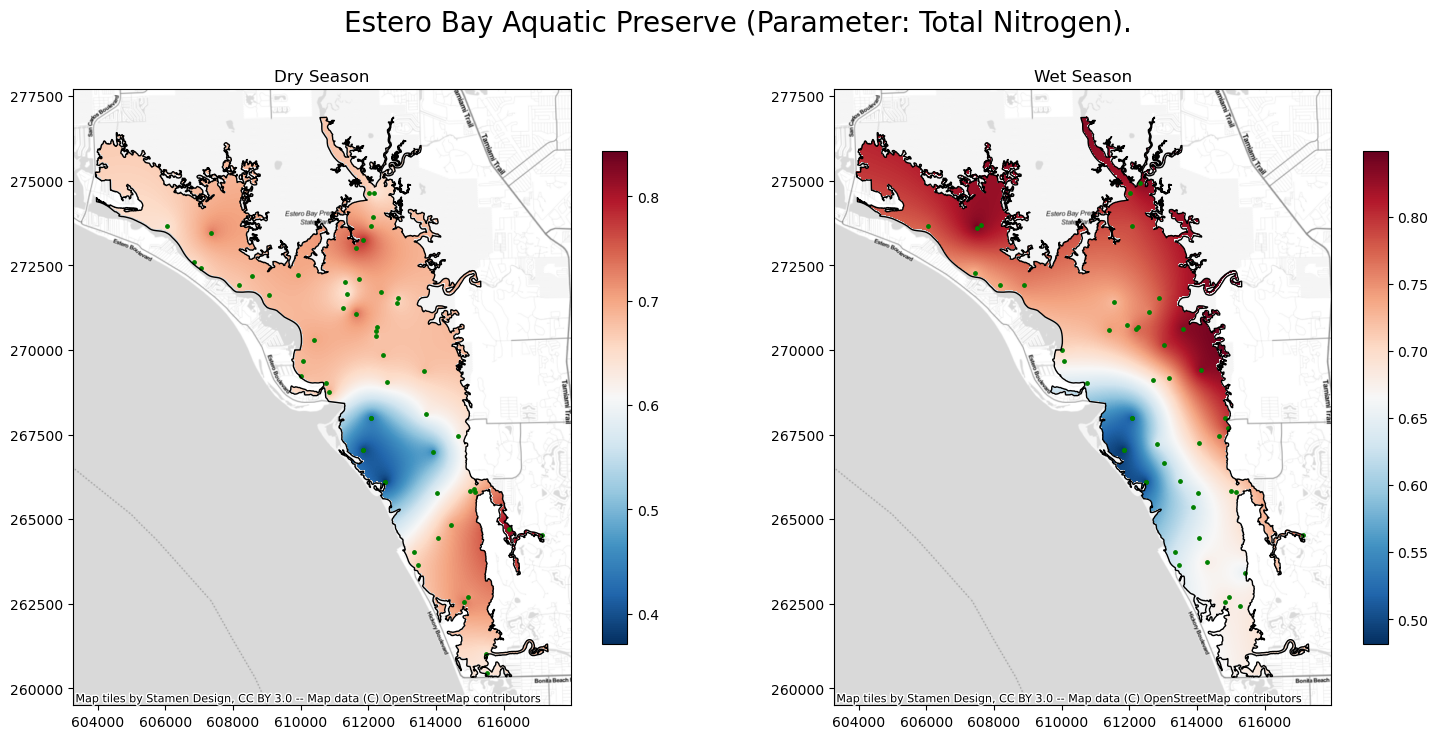

In [110]:
interpolation_method("2016","ebk")

This is Regression Kriging interpolation method
--- Time lapse: 143.81388115882874 seconds ---


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


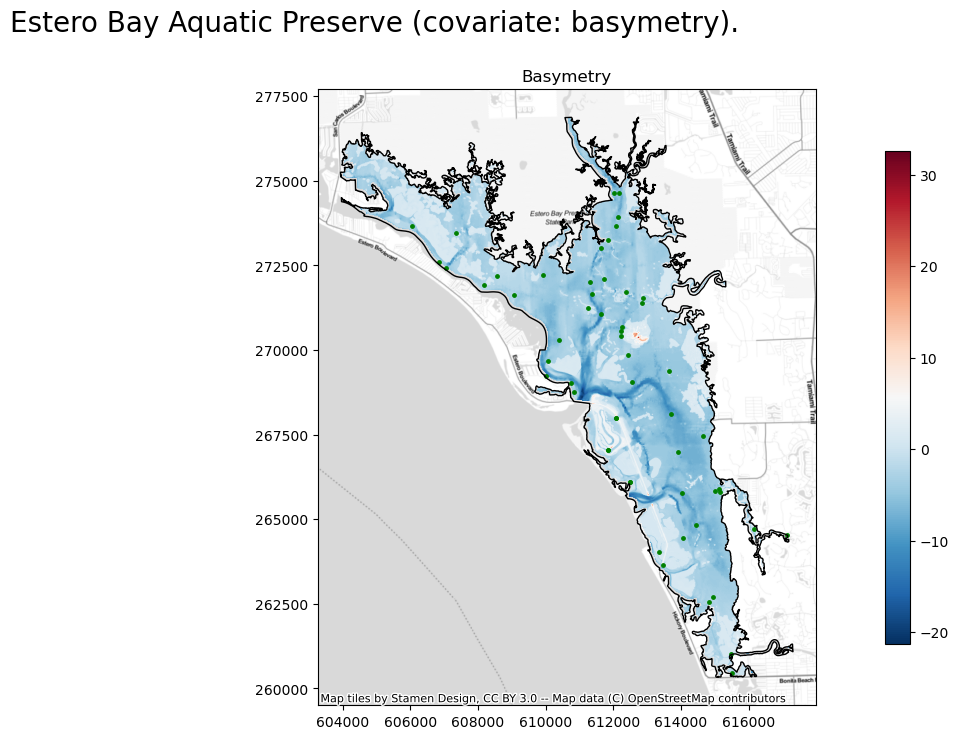

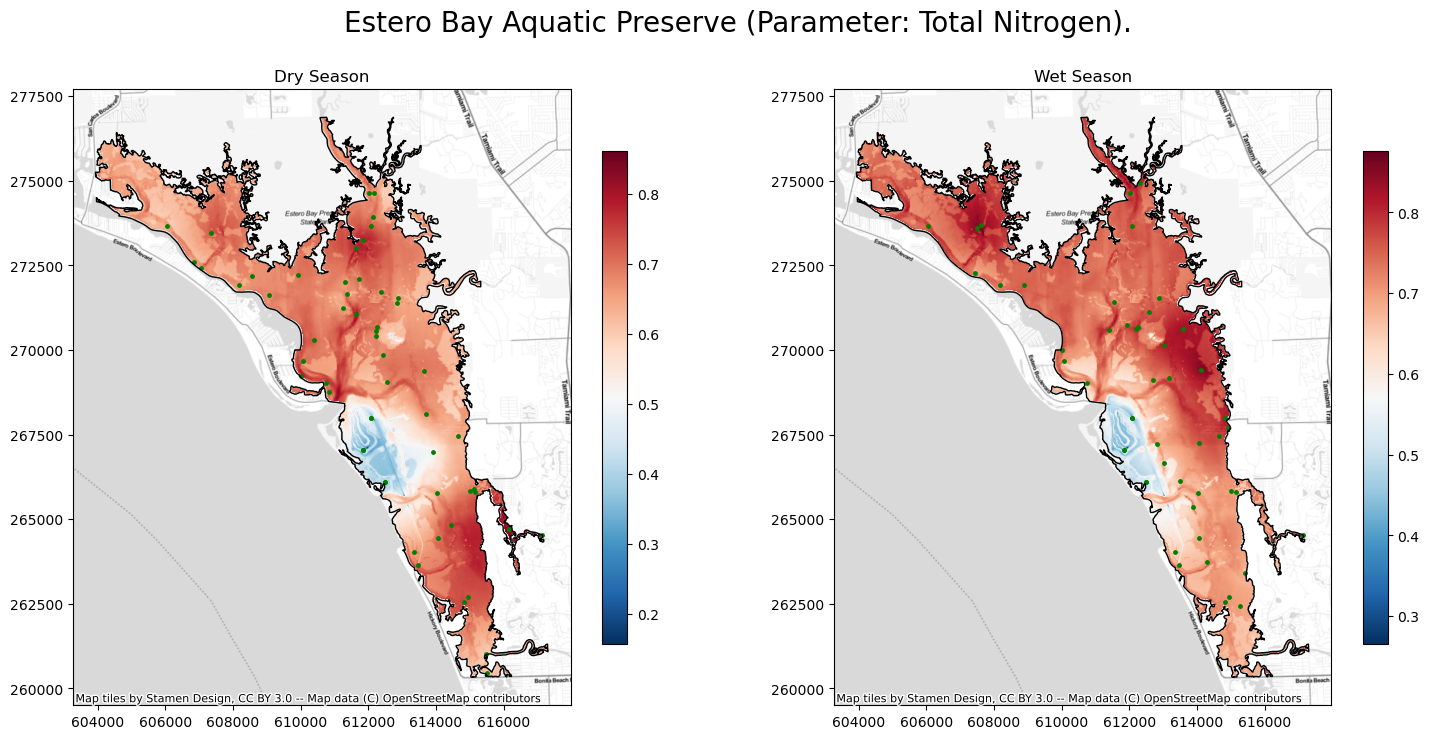

In [111]:
interpolation_method("2016","rk")

In [112]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\TNwetok_GA.lyrx'>

In [113]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [114]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging    -0.0052                 -0.002               0.2312

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging    -0.0206                -0.0086               0.2333

In [115]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\TNwetIDW_GA.lyrx'>

In [116]:
inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path+Para_ab + "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [117]:
cvResult.meanStandardized

'NaN'

In [118]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting    -0.0251                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.2602

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     -0.015                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.2656

In [119]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\TNwetEBK_GA.lyrx'>

In [120]:
inLayer = gis_path+Para_ab + "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path+Para_ab + "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [121]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0033                -0.0085   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.2307

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0021                -0.0045   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.2281

In [122]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02202\\TNwetRK_GA.lyrx'>

In [123]:
inLayer = gis_path+Para_ab + "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path+Para_ab + "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [124]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0097                -0.0363               0.2284

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0094                -0.0378               0.2274

In [125]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry3 = pd.concat([sumStat1,sumStat2])

In [126]:
print("Summary of interpolation assessment of TN in dry season data")
sumStatDry3

Summary of interpolation assessment of TN in dry season data


meanError meanStandardizedError  \
Ordinary Kriging              -0.0052                -0.002   
Inverse Distance Weighting    -0.0251                   Nan   
Empirical Bayesian Kriging    -0.0033               -0.0085   
Regression Kriging            -0.0097               -0.0363   

                            rootMeanSquareError  
Ordinary Kriging                         0.2312  
Inverse Distance Weighting               0.2602  
Empirical Bayesian Kriging               0.2307  
Regression Kriging                       0.2284

In [127]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet3 = pd.concat([sumStat3,sumStat4])

In [128]:
print("Summary of interpolation assessment of TN in wet season data")
sumStatWet3

Summary of interpolation assessment of TN in wet season data


meanError meanStandardizedError  \
Ordinary Kriging              -0.0206               -0.0086   
Inverse Distance Weighting    -0.0150                   Nan   
Empirical Bayesian Kriging    -0.0021               -0.0045   
Regression Kriging            -0.0094               -0.0378   

                            rootMeanSquareError  
Ordinary Kriging                         0.2333  
Inverse Distance Weighting               0.2656  
Empirical Bayesian Kriging               0.2281  
Regression Kriging                       0.2274

In [129]:
print("Summary of interpolation assessment of DO in wet season data")
sumStatDry

Summary of interpolation assessment of DO in wet season data


meanError meanStandardizedError  \
Ordinary Kriging              -0.0219               -0.0119   
Inverse Distance Weighting     0.1828                   Nan   
Empirical Bayesian Kriging     0.0169                0.0073   
Regression Kriging            -0.0417                -0.039   

                            rootMeanSquareError  
Ordinary Kriging                         1.1988  
Inverse Distance Weighting               1.2322  
Empirical Bayesian Kriging               1.1277  
Regression Kriging                       1.0938

In [130]:
print("Summary of interpolation assessment of DO in wet season data")
sumStatWet

Summary of interpolation assessment of DO in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0863                  0.04   
Inverse Distance Weighting     0.0976                   Nan   
Empirical Bayesian Kriging     0.0388                0.0192   
Regression Kriging            -0.0448                -0.041   

                            rootMeanSquareError  
Ordinary Kriging                         1.0353  
Inverse Distance Weighting               1.1434  
Empirical Bayesian Kriging               1.0655  
Regression Kriging                       1.0197

In [131]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatDry2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               1.1431                0.4975   
Inverse Distance Weighting     1.6566                   Nan   
Empirical Bayesian Kriging     0.8991                0.1159   
Regression Kriging             0.6190                0.0755   

                            rootMeanSquareError  
Ordinary Kriging                         6.6931  
Inverse Distance Weighting               5.3286  
Empirical Bayesian Kriging               3.2550  
Regression Kriging                       4.0410

In [132]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatWet2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               1.3967                0.6163   
Inverse Distance Weighting     1.2946                   Nan   
Empirical Bayesian Kriging     1.0383                0.1194   
Regression Kriging            -0.0646                0.0425   

                            rootMeanSquareError  
Ordinary Kriging                         6.2481  
Inverse Distance Weighting               5.7211  
Empirical Bayesian Kriging               5.7064  
Regression Kriging                       4.4247